In [1]:
import sys
import os 
import cv2 
import numpy as np
from glob import glob
import torch as th 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt

sys.path.append("../src")
from utils.load_tof_images import create_from_zip_absolute  as load_assignment_data
from data_loader.data_loader_assignment import CreateAssignemntDataset
from utils.data_transforms import pre_process

### Functions 

In [2]:
def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)

def tensor_to_numpy_image(image,rgb=True):
    image = image.permute(1,0,2,3).squeeze(axis=0).cpu().detach().numpy()
    if rgb:
        image = image.squeeze(axis=1)
        return np.array(image.transpose(1, 2, 0)*255, dtype=np.uint8) 
    else:
        return image.squeeze(axis=0)

def DepthNorm(x, maxDepth):
    return maxDepth / x

In [3]:
device = 'cuda' if th.cuda.is_available() else 'cpu'


data_path = "/mnt/e/Personal/Samarth/repository/Depth-Estimation/data/depth_data_child/360_scan"
child_rgb_files = glob(data_path+"/*/rgb/*")
child_depth_files = glob(data_path+'/*/depth/*')
print("Total number of RGB imgaes :",len(child_rgb_files))
print("Total number of Depth imgaes :",len(child_depth_files))

Total number of RGB imgaes : 257
Total number of Depth imgaes : 257


In [4]:
from sklearn.model_selection import train_test_split

X_train , X_test = train_test_split(child_rgb_files,train_size=0.80,test_size =0.20,random_state=45)
print("Train images ",len(X_train))
print("Test Imgages ",len(X_test))

Y_train = [fname.replace('rgb','depth') for fname in X_train]
Y_test = [fname.replace('rgb','depth') for fname in X_test]

# calib_fpath = os.path.dirname(rgb_fpath).replace('rgb','calibration/0')

Train images  205
Test Imgages  52


In [5]:
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        image = self.to_tensor(image)
        # image = image.div(255.0)

        depth = np.expand_dims(depth,axis=-1)
        depth = self.to_tensor(depth).float() * 10 # depth Scale
        # depth = depth.resize((320, 240))
        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        if isinstance(pic, np.ndarray):
            img = th.from_numpy(np.transpose(pic,(2, 0, 1)))
            return img.float()  # .div(255) does not give good results for depth model 

def pre_process():
    return transforms.Compose([ToTensor()])

_RESIZE_TO = (384, 384) 

def transform_image():
    return transforms.Compose(
            [
            torchvision.transforms.Resize(_RESIZE_TO),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.ToPILImage(),
            ]
        )

def collate_fn(examples):
    pixel_values = torch.stack([example["image"] for example in examples])
    labels = torch.stack([example["depth"].squeeze() for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [6]:
training_dataset = CreateAssignemntDataset(X_train,Y_train,process_image=pre_process())
train_loader  = DataLoader(training_dataset, batch_size= 1, shuffle=True, num_workers=1)

test_dataset = CreateAssignemntDataset(X_test,Y_test,process_image=pre_process())
test_loader =  DataLoader(test_dataset, batch_size= 1, shuffle=True, num_workers=1)

In [7]:
def predict_with_opensource_model(image,model,processor,image_size=(240,320)):
    pixel_values = processor(image, return_tensors="pt").pixel_values   
    with th.no_grad():
        outputs = model(pixel_values)
        predicted_depth = outputs.predicted_depth
    # interpolate to original size
    prediction = th.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_size,
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    output = prediction.numpy()
    return output


def inference_rgbimage(rgb_image,depth_image_size=(240,320),depth_scale=0.01,checkpoint="vinvino02/glpn-nyu"):
    result = np.zeros_like(rgb_image)
    
    result  = predict_with_opensource_model(rgb_image,
                                            model=DEPTH_MODEL,
                                            processor=IMAGE_PROCESSOR,
                                            image_size=depth_image_size)

    formatted = (result*255).astype(np.float32)
    return formatted*depth_scale

### Load Model 

In [8]:
import torch 
from transformers import (
    GLPNFeatureExtractor,
    GLPNForDepthEstimation,
    Trainer,
    TrainingArguments,
)
from datetime import datetime 
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

_TIMESTAMP = datetime.utcnow().strftime("%y%m%d-%H%M%S")
_EPOCHS = 10 
_SEED = 2022
_MODEL_NAME = "vinvino02/glpn-nyu"

# feature_extractor = GLPNFeatureExtractor.from_pretrained(_MODEL_NAME)
# model = GLPNForDepthEstimation.from_pretrained(_MODEL_NAME)

IMAGE_PROCESSOR = AutoImageProcessor.from_pretrained("vinvino02/glpn-nyu")
DEPTH_MODEL = AutoModelForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

/home/samartht/miniconda3/envs/pyvision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
train_iter = iter(train_loader)
data = next(train_iter)

rgb = np.squeeze(data['image'].detach().cpu().numpy(),0)
depth = np.squeeze(data['depth'].detach().cpu().numpy(),0)

predicted_depth_image = inference_rgbimage(rgb,depth_image_size=(384,384))

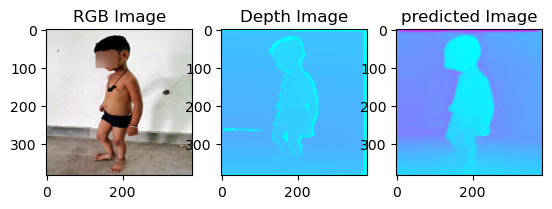

In [9]:
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(np.transpose(rgb/255.0,(1,2,0)))

plt.subplot(1,3,2)
plt.title("Depth Image")
plt.imshow(np.transpose(depth,(1,2,0)),cmap='cool')

plt.subplot(1,3,3)
plt.title("predicted Image")
plt.imshow(predicted_depth_image,cmap='cool')
plt.show()

### Initializing training arguments 

In [9]:
# plesae look at https://github.com/huggingface/transformers/issues/9160

model_name = _MODEL_NAME.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-diode-{_TIMESTAMP}", 
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    # per_device_train_batch_size= , # batch size per device during training
    # per_device_eval_batch_size= ,  # batch size for evaluation
    gradient_accumulation_steps=1,
    num_train_epochs=_EPOCHS,
    warmup_ratio=0.1,
    weight_decay=0.0,
    logging_steps=25,
    load_best_model_at_end=True,
    push_to_hub=False,
    fp16=False, # If loss is nan try toggle the fp16 flag 
    seed=_SEED,
)

## Define Metric 

In [10]:
# Taken from https://github.com/diode-dataset/diode-devkit/blob/master/metrics.py


def errors(eval_preds):
    pred, gt = eval_preds
    valid_mask = gt > 0
    pred_eval, gt_eval = pred[valid_mask], gt[valid_mask]

    abs_diff = np.abs(pred_eval - gt_eval)

    mae = np.mean(abs_diff)
    rmse = np.sqrt(np.mean(np.power(abs_diff, 2)))
    abs_rel = np.mean(abs_diff / gt_eval)

    log_abs_diff = np.abs(np.log10(pred_eval) - np.log10(gt_eval))

    log_mae = np.mean(log_abs_diff)
    log_rmse = np.sqrt(np.mean(np.power(log_abs_diff, 2)))

    return dict(
        mae=mae,
        rmse=rmse,
        abs_rel=abs_rel,
        log_mae=log_mae,
        log_rmse=log_rmse,
    )

### Initializing Trainer and training...

In [11]:
trainer = Trainer(
    DEPTH_MODEL,
    training_args,
    train_dataset=training_dataset,
    eval_dataset=test_dataset,
    tokenizer=IMAGE_PROCESSOR,
    compute_metrics=errors,
    data_collator=collate_fn,
)
_ = trainer.train()

/home/samartht/miniconda3/envs/pyvision/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mae,Rmse,Abs Rel,Log Mae,Log Rmse
1,1.120900,0.851813,7.712622,8.028711,0.723974,0.479451,0.494714
2,0.673600,0.473058,4.722721,5.067347,0.535355,0.224911,0.249086
3,0.405500,0.364047,2.627671,3.240595,0.405518,0.112178,0.167362
4,0.359300,0.357850,2.656935,3.249472,0.393258,0.113213,0.165711
5,0.354600,0.352126,2.675599,3.265356,0.374827,0.114129,0.164134
6,0.347700,0.347143,2.641746,3.241401,0.361679,0.112536,0.161932
7,0.344200,0.343053,2.647022,3.249047,0.348374,0.112913,0.160770
8,0.341200,0.340680,2.621479,3.231253,0.342240,0.111568,0.159507
9,0.335400,0.338927,2.634063,3.243538,0.335418,0.112331,0.159275
10,0.335000,0.338579,2.622363,3.235829,0.334195,0.111682,0.158909


In [14]:
import pandas as pd 
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history.fillna(0)
log_history = log_history.groupby(['epoch']).sum()
log_history.head()

,loss,learning_rate,step,eval_loss,eval_mae,eval_rmse,eval_abs_rel,eval_log_mae,eval_log_rmse,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,,,
0.96,1.1209,0.000010,25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
1.00,0.0000,0.000000,26,0.851813,7.712622,8.028711,0.723974,0.479451,0.494714,43.7867,1.188,0.160,0.0,0.0,0.0,0.0,0.0
1.92,0.6736,0.000009,50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
2.00,0.0000,0.000000,52,0.473058,4.722721,5.067347,0.535355,0.224911,0.249086,51.3013,1.014,0.136,0.0,0.0,0.0,0.0,0.0
2.88,0.4055,0.000008,75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000,0.0,0.0,0.0,0.0,0.0


## Plot Loss Training and Validation

array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>,
       <Axes: xlabel='epoch'>], dtype=object)

<Figure size 1200x1700 with 0 Axes>

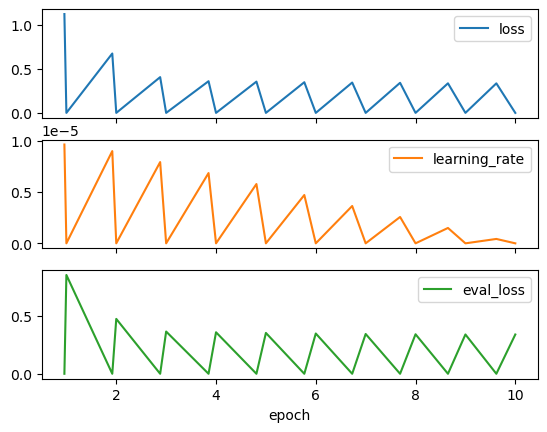

In [27]:
plt.figure(figsize=(12,17))
log_history[["loss","learning_rate",'eval_loss']].plot(subplots=True)

## Plot Metric 

array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>,
       <Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>,
       <Axes: xlabel='epoch'>], dtype=object)

<Figure size 1200x1700 with 0 Axes>

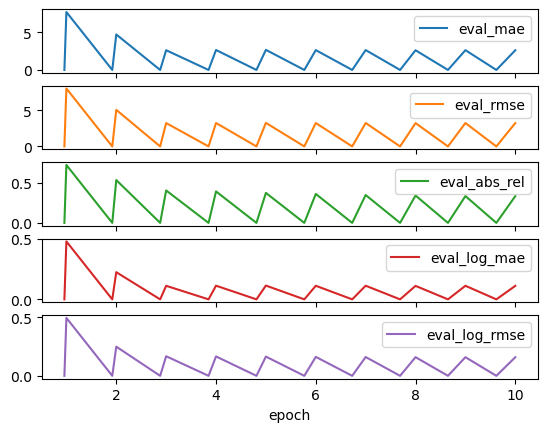

In [28]:
plt.figure(figsize=(12,17))
log_history[["eval_mae", "eval_rmse","eval_abs_rel","eval_log_mae","eval_log_rmse"]].plot(subplots=True)

## save Model 

In [29]:
model_dir = "../model/"
trainer.save_model(model_dir)

# Load Tranied MOdel 

In [30]:
# Load model
IMAGE_PROCESSOR = AutoImageProcessor.from_pretrained("../model")
DEPTH_MODEL = AutoModelForDepthEstimation.from_pretrained("../model/")

In [36]:
test_iter = iter(test_loader)
data = next(test_iter)

rgb = np.squeeze(data['image'].detach().cpu().numpy(),0)
depth = np.squeeze(data['depth'].detach().cpu().numpy(),0)

predicted_depth_image = inference_rgbimage(rgb,depth_image_size=(384,384))

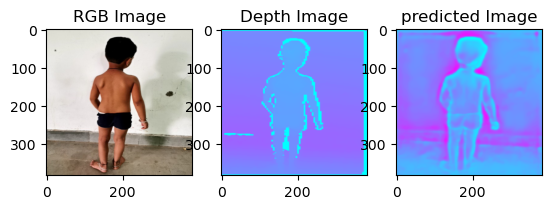

In [37]:
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(np.transpose(rgb/255.0,(1,2,0)))

plt.subplot(1,3,2)
plt.title("Depth Image")
plt.imshow(np.transpose(depth,(1,2,0)),cmap='cool')

plt.subplot(1,3,3)
plt.title("predicted Image")
plt.imshow(predicted_depth_image,cmap='cool')
plt.show()